In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

# prepare colors for plot
colors = ['#c7eae5','#008C8D']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana", cmap)
phasec_m = sns.color_palette("dana", n_colors=27)


from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

# prepare colors for plot
colors = ['#fee6ce','#d94801']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana_f", cmap)
phasec_f = sns.color_palette("dana_f", n_colors=27)

In [4]:
## update data
def filter_df(df):
    max=62
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

## update data
def filter_df_long(df):
    max=62
    thresh=8
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    age_counts = df.index.get_level_values('age').value_counts()
    ages_greater = list(age_counts[age_counts > thresh].index)
    return df.loc[data.index.get_level_values('age').isin(ages_greater)]

In [5]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [6]:
# arrange male ontogeny data
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_males_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid','mouse']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])
# choose 16 mice from all dataset
random_seed = 0
n=16
data_all = data_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False,random_state=random_seed) if len(x)>n else x.sample(n=len(x),replace=False,random_state=random_seed)).reset_index(level=0, drop=True)
data_all = data_all[sorted(data_all.columns)]
m_data = data_all.query('age<100')

In [7]:
# arrange male ontogeny data
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_females_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid','mouse']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])
# choose 16 mice from all dataset
random_seed = 0
n=16
data_all = data_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False,random_state=random_seed) if len(x)>n else x.sample(n=len(x),replace=False,random_state=random_seed)).reset_index(level=0, drop=True)
data_all = data_all[sorted(data_all.columns)]
f_data = data_all.query('age<100')

In [8]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_v2_females_relabeled_usage_matrix_v00.parquet').astype(float)
df = pd.read_parquet(path)

# arrange data
data= df.groupby(['age','uuid','mouse']).mean()

In [9]:
# find first recording per week in the longtogeny dataset
from collections import defaultdict
ages = list(long_data.index.get_level_values('age').unique())
# Group entries by week
week_entries = defaultdict(list)
for age in ages:
    week, day = str(age).split('.')
    week_entries[week].append(age)

# Find the entry with the lowest day for each week
lowest_day_entries = [min(entries, key=lambda x: float(str(x).split('.')[1])) for entries in week_entries.values()]
long_data = long_data[long_data.index.get_level_values('age').isin(lowest_day_entries)]
long_data = long_data.rename_axis(index={'age': 'age_old'})
long_data['age'] = np.floor(long_data.index.get_level_values('age_old')).astype(int)
long_data.set_index('age',inplace=True, append=True)

In [10]:
# use only common ages
long_ages = long_data.index.get_level_values('age').unique().to_numpy()
f_ages = f_data.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(long_ages,f_ages))
f_data = f_data.loc[f_data.index.get_level_values('age').isin(cages)]
f_data['exp'] = 'ont'
f_data.set_index('exp',inplace=True,append=True)


m_data = m_data.loc[m_data.index.get_level_values('age').isin(cages)]
m_data['exp'] = 'ont'
m_data.set_index('exp',inplace=True,append=True)

long_data = long_data.loc[long_data.index.get_level_values('age').isin(cages)]
long_data['exp'] = 'long'
long_data.set_index('exp',inplace=True,append=True)

long_f = long_data.copy()

In [11]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_v2_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

# arrange data
data = df.astype(float, errors='ignore')
data= filter_df_long(data).groupby(['age','uuid','mouse']).mean()
data = data.query('age<100')
long_data = data[sorted(data.columns)].copy()

# find first recording per week in the longtogeny dataset
from collections import defaultdict
ages = list(long_data.index.get_level_values('age').unique())
# Group entries by week
week_entries = defaultdict(list)
for age in ages:
    week, day = str(age).split('.')
    week_entries[week].append(age)

# Find the entry with the lowest day for each week
lowest_day_entries = [min(entries, key=lambda x: float(str(x).split('.')[1])) for entries in week_entries.values()]
long_data = long_data[long_data.index.get_level_values('age').isin(lowest_day_entries)]
long_data = long_data.rename_axis(index={'age': 'age_old'})
long_data['age'] = np.floor(long_data.index.get_level_values('age_old')).astype(int)
long_data.set_index('age',inplace=True, append=True)

# use only common ages
long_data = long_data.loc[long_data.index.get_level_values('age').isin(cages)]
long_data['exp'] = 'long'
long_data.set_index('exp',inplace=True,append=True)

long_m = long_data.copy()

In [12]:
#m_data= m_data.groupby('age').mean()
f_data= f_data.groupby(['age','uuid']).mean()
m_data= m_data.groupby(['age','uuid']).mean()
long_f = long_f.groupby(['age','mouse','uuid']).mean()
long_m = long_m.groupby(['age','mouse','uuid']).mean()

In [13]:
## normalize by min/max
avg_male = mm_norm_col(m_data)
avg_female = mm_norm_col(f_data)
avg_long_f = mm_norm_col(long_f)
avg_long_m = mm_norm_col(long_f)

In [14]:
## not normalize by min/max
avg_male = m_data.copy()
avg_female = f_data.copy()
avg_long_f = long_f.copy()
avg_long_m = long_m.copy()

## male ontogeny

In [15]:
# calculate distance for chronological age and pseudo age
# for age
age_data=avg_male.copy()
bins=[]
kld_age=[]
u_age=[]
c_age=[]
#exp=[]
for age,_df in enumerate(age_data.groupby('age')):
    bins.extend(_df[1].index.get_level_values('age').to_numpy())
    #exp.extend(['age']*len(_df[1]))
    data_temp = _df[1].to_numpy()
    kld_temp = squareform(pdist(data_temp, metric='jensenshannon'))
    utemp = pairwise_distances(data_temp)
    ctemp = pairwise_distances(data_temp, metric = 'cosine')
    kld_age.extend(np.mean(kld_temp, axis=1))
    u_age.extend(np.mean(utemp, axis=1))
    c_age.extend(np.mean(ctemp, axis=1))

In [16]:
df=pd.DataFrame()
df['bins']=bins
df['jsd']=kld_age
df['euc']=u_age
df['cosine']=c_age

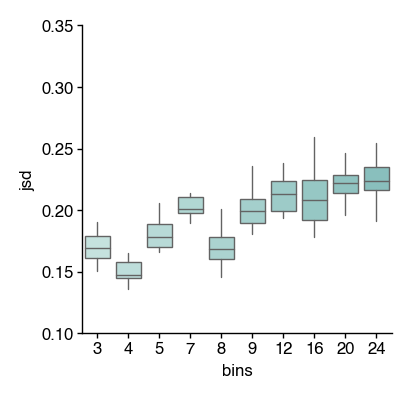

In [17]:
# plot jsd values values
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.boxplot(data=df, x="bins", y="jsd",
             palette = phasec_m, dodge=True, showfliers=False, linewidth=0.5, showcaps=False)
ax.set_ylim(0.1,0.35)
sns.despine()

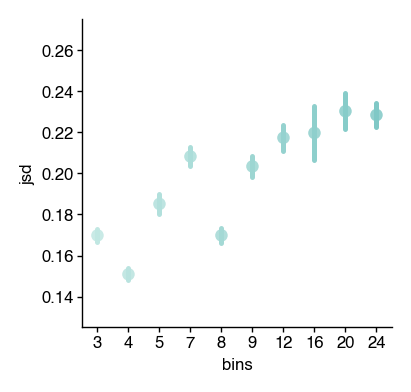

In [18]:
## show mean
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.pointplot(data=df, x="bins", y="jsd", 
            #notch= True,
            estimator='mean',
            #hue='age',
            errorbar = 'se',
            #palette = ['grey','#6a51a3'], 
            palette = phasec_m, 
            #dodge=True,
            #alpha=0.5,
            join=False)
ax.set_ylim(0.125,0.275)
plt.setp(ax.collections, alpha=.85)
plt.setp(ax.collections, edgecolor='none')
sns.despine()

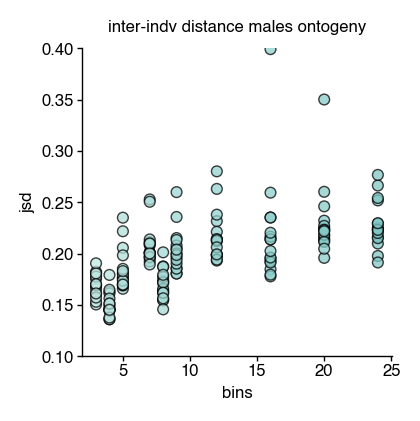

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.scatterplot(data=df, x=df.bins.astype('int'), y="jsd", hue=bins, palette = phasec_m, alpha=0.75,s=15,edgecolor='black', 
              linewidth=0.5, legend=False)

#sns.lineplot(data=df_sh, x="bins", y="jsd", ax=ax, color='black', estimator='mean', errorbar=('sd', 2))
ax.set_ylim(0.1,0.40)
ax.set_title('inter-indv distance males ontogeny')
sns.despine()

In [20]:
## for male longtogent

In [21]:
# calculate distance for chronological age and pseudo age
# for age
age_data=avg_long_m.copy()
bins=[]
kld_age=[]
u_age=[]
c_age=[]
#exp=[]
for age,_df in enumerate(age_data.groupby('age')):
    bins.extend(_df[1].index.get_level_values('age').to_numpy())
    #exp.extend(['age']*len(_df[1]))
    data_temp = _df[1].to_numpy()
    kld_temp = squareform(pdist(data_temp, metric='jensenshannon'))
    utemp = pairwise_distances(data_temp)
    ctemp = pairwise_distances(data_temp, metric = 'cosine')
    kld_age.extend(np.mean(kld_temp, axis=1))
    u_age.extend(np.mean(utemp, axis=1))
    c_age.extend(np.mean(ctemp, axis=1))

In [22]:
df=pd.DataFrame()
df['bins']=bins
df['jsd']=kld_age
df['euc']=u_age
df['cosine']=c_age

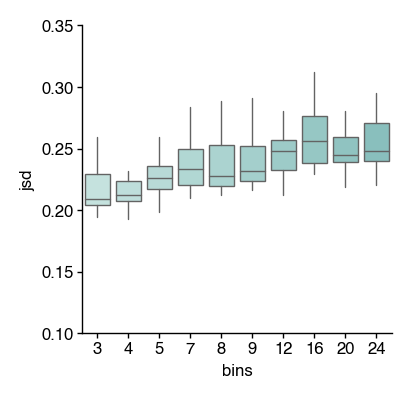

In [23]:
# plot jsd values values
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.boxplot(data=df, x="bins", y="jsd",
             palette = phasec_m, dodge=True, showfliers=False, linewidth=0.5, showcaps=False)
ax.set_ylim(0.1,0.35)
sns.despine()

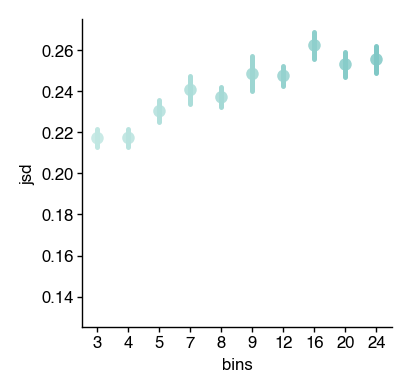

In [24]:
## show mean
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.pointplot(data=df, x="bins", y="jsd", 
            #notch= True,
            estimator='mean',
            #hue='age',
            errorbar = 'se',
            #palette = ['grey','#6a51a3'], 
            palette = phasec_m, 
            #dodge=True,
            #alpha=0.5,
            join=False)
ax.set_ylim(0.125,0.275)
plt.setp(ax.collections, alpha=.85)
plt.setp(ax.collections, edgecolor='none')
sns.despine()

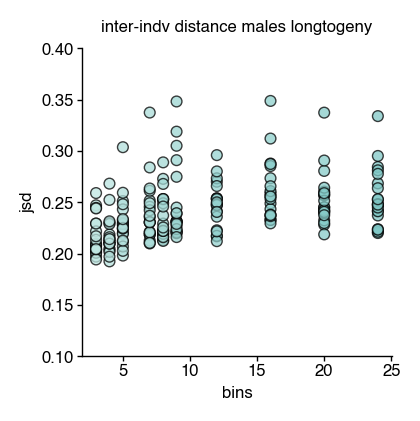

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.scatterplot(data=df, x=df.bins.astype('int'), y="jsd", hue=bins, palette = phasec_m, alpha=0.75,s=15,edgecolor='black', 
              linewidth=0.5, legend=False)

#sns.lineplot(data=df_sh, x="bins", y="jsd", ax=ax, color='black', estimator='mean', errorbar=('sd', 2))
ax.set_ylim(0.1,0.40)
ax.set_title('inter-indv distance males longtogeny')
sns.despine()

In [26]:
## for female ontogeny

In [27]:
# calculate distance for chronological age and pseudo age
# for age
age_data=avg_female.copy()
bins=[]
kld_age=[]
u_age=[]
c_age=[]
#exp=[]
for age,_df in enumerate(age_data.groupby('age')):
    bins.extend(_df[1].index.get_level_values('age').to_numpy())
    #exp.extend(['age']*len(_df[1]))
    data_temp = _df[1].to_numpy()
    kld_temp = squareform(pdist(data_temp, metric='jensenshannon'))
    utemp = pairwise_distances(data_temp)
    ctemp = pairwise_distances(data_temp, metric = 'cosine')
    kld_age.extend(np.mean(kld_temp, axis=1))
    u_age.extend(np.mean(utemp, axis=1))
    c_age.extend(np.mean(ctemp, axis=1))

In [28]:
df=pd.DataFrame()
df['bins']=bins
df['jsd']=kld_age
df['euc']=u_age
df['cosine']=c_age

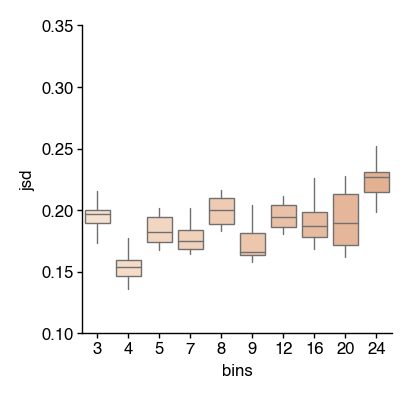

In [29]:
# plot jsd values values
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.boxplot(data=df, x="bins", y="jsd",
             palette = phasec_f, dodge=True, showfliers=False, linewidth=0.5, showcaps=False)
ax.set_ylim(0.1,0.35)
sns.despine()

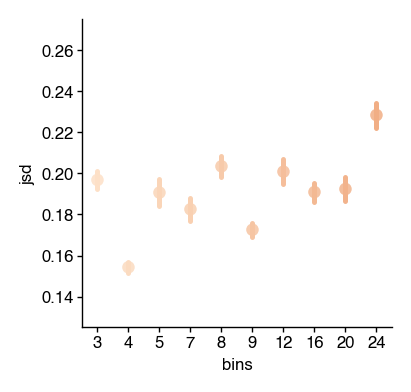

In [30]:
## show mean
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.pointplot(data=df, x="bins", y="jsd", 
            #notch= True,
            estimator='mean',
            #hue='age',
            errorbar = 'se',
            #palette = ['grey','#6a51a3'], 
            palette = phasec_f, 
            #dodge=True,
            #alpha=0.5,
            join=False)
ax.set_ylim(0.125,0.275)
plt.setp(ax.collections, alpha=.85)
plt.setp(ax.collections, edgecolor='none')
sns.despine()

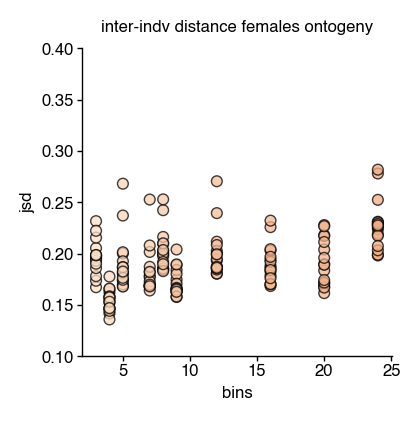

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.scatterplot(data=df, x=df.bins.astype('int'), y="jsd", hue=bins, palette = phasec_f, alpha=0.75,s=15,edgecolor='black', 
              linewidth=0.5, legend=False)

#sns.lineplot(data=df_sh, x="bins", y="jsd", ax=ax, color='black', estimator='mean', errorbar=('sd', 2))
ax.set_ylim(0.1,0.40)
ax.set_title('inter-indv distance females ontogeny')
sns.despine()

In [32]:
# calculate distance for chronological age and pseudo age
# for age
age_data=avg_long_f.copy()
bins=[]
kld_age=[]
u_age=[]
c_age=[]
#exp=[]
for age,_df in enumerate(age_data.groupby('age')):
    bins.extend(_df[1].index.get_level_values('age').to_numpy())
    #exp.extend(['age']*len(_df[1]))
    data_temp = _df[1].to_numpy()
    kld_temp = squareform(pdist(data_temp, metric='jensenshannon'))
    utemp = pairwise_distances(data_temp)
    ctemp = pairwise_distances(data_temp, metric = 'cosine')
    kld_age.extend(np.mean(kld_temp, axis=1))
    u_age.extend(np.mean(utemp, axis=1))
    c_age.extend(np.mean(ctemp, axis=1))

In [33]:
df=pd.DataFrame()
df['bins']=bins
df['jsd']=kld_age
df['euc']=u_age
df['cosine']=c_age

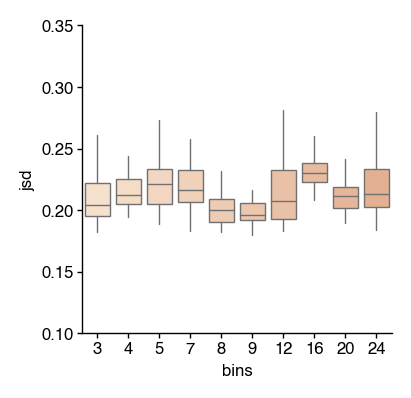

In [34]:
# plot jsd values values
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.boxplot(data=df, x="bins", y="jsd",
             palette = phasec_f, dodge=True, showfliers=False, linewidth=0.5, showcaps=False)
ax.set_ylim(0.1,0.35)
sns.despine()

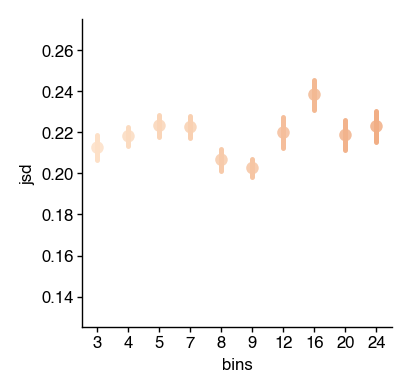

In [35]:
## show mean
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.pointplot(data=df, x="bins", y="jsd", 
            #notch= True,
            estimator='mean',
            #hue='age',
            errorbar = 'se',
            #palette = ['grey','#6a51a3'], 
            palette = phasec_f, 
            #dodge=True,
            #alpha=0.5,
            join=False)
ax.set_ylim(0.125,0.275)
plt.setp(ax.collections, alpha=.85)
plt.setp(ax.collections, edgecolor='none')
sns.despine()

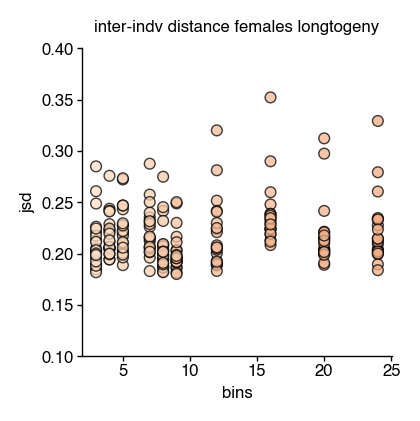

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.scatterplot(data=df, x=df.bins.astype('int'), y="jsd", hue=bins, palette = phasec_f, alpha=0.75,s=15,edgecolor='black', 
              linewidth=0.5, legend=False)

#sns.lineplot(data=df_sh, x="bins", y="jsd", ax=ax, color='black', estimator='mean', errorbar=('sd', 2))
ax.set_ylim(0.1,0.40)
ax.set_title('inter-indv distance females longtogeny')
sns.despine()